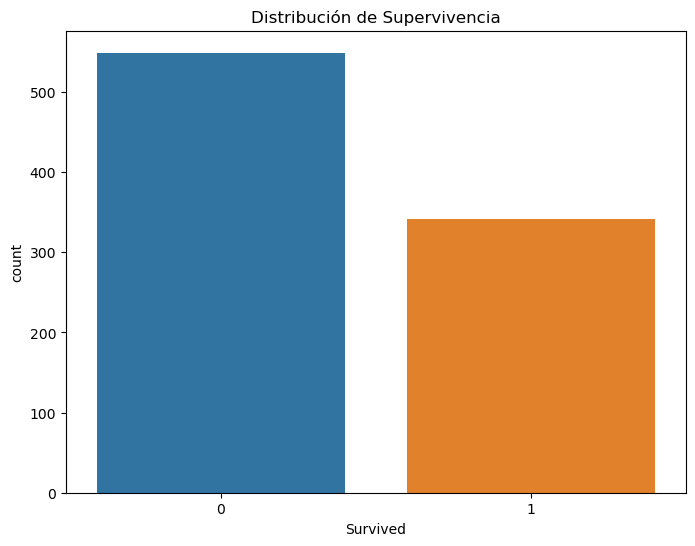

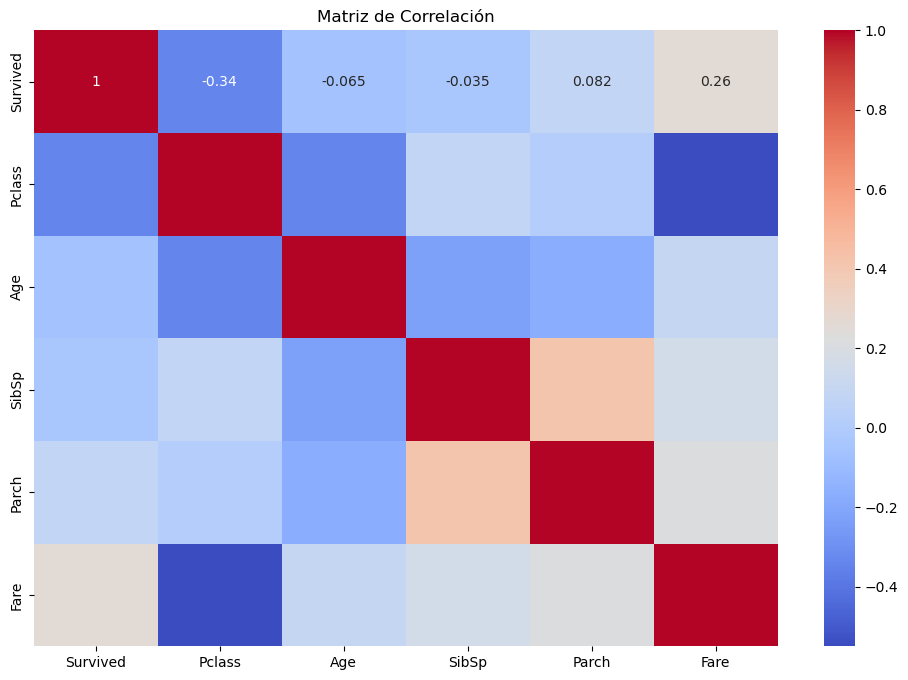

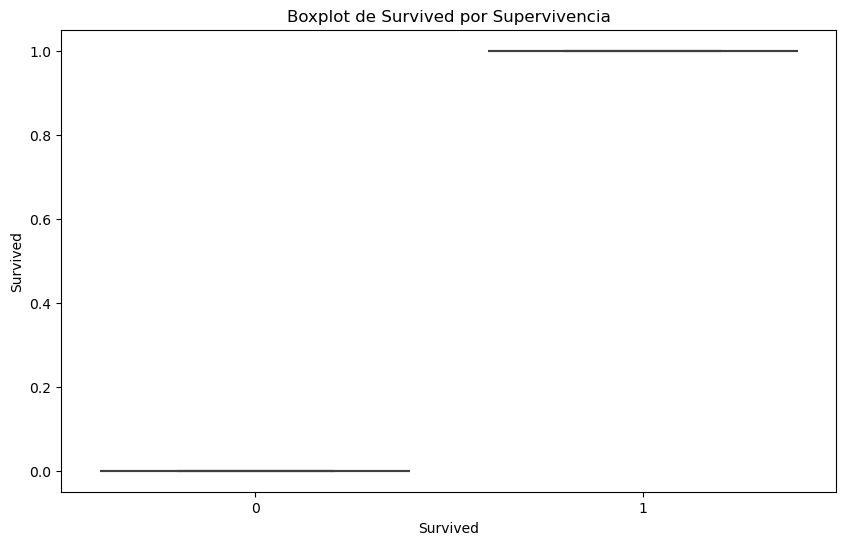

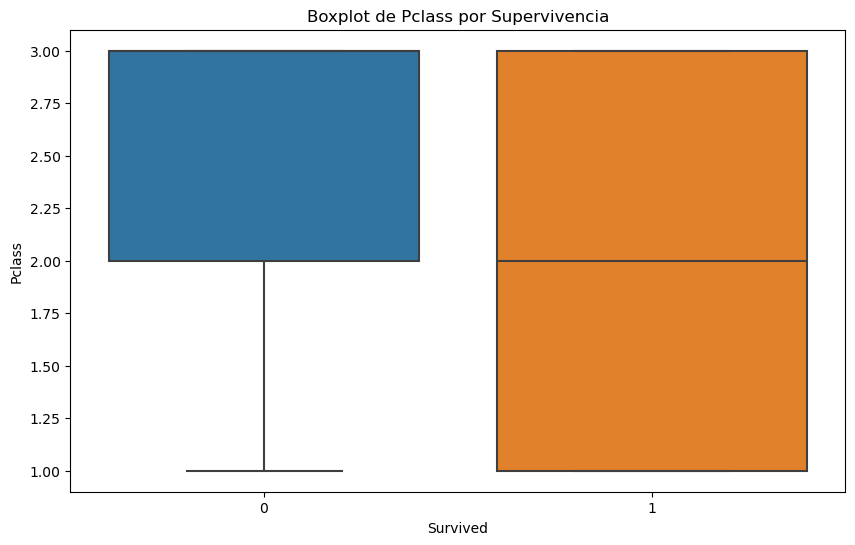

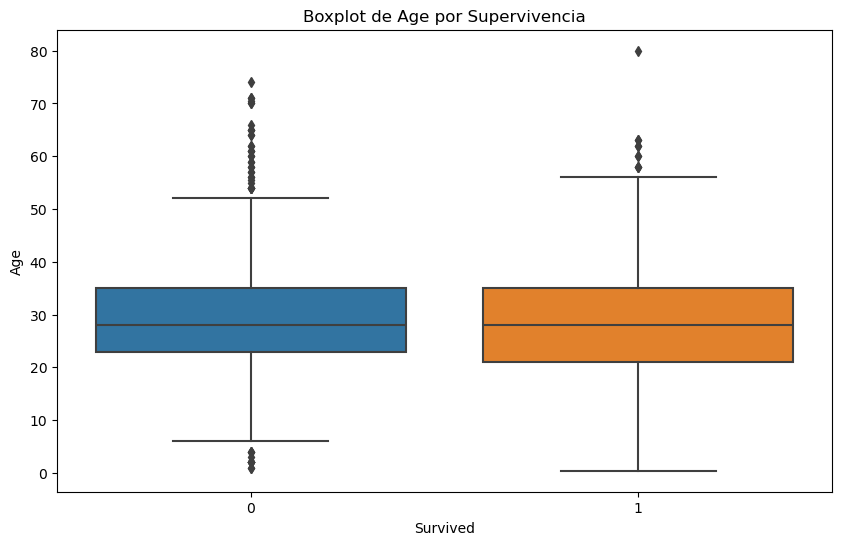

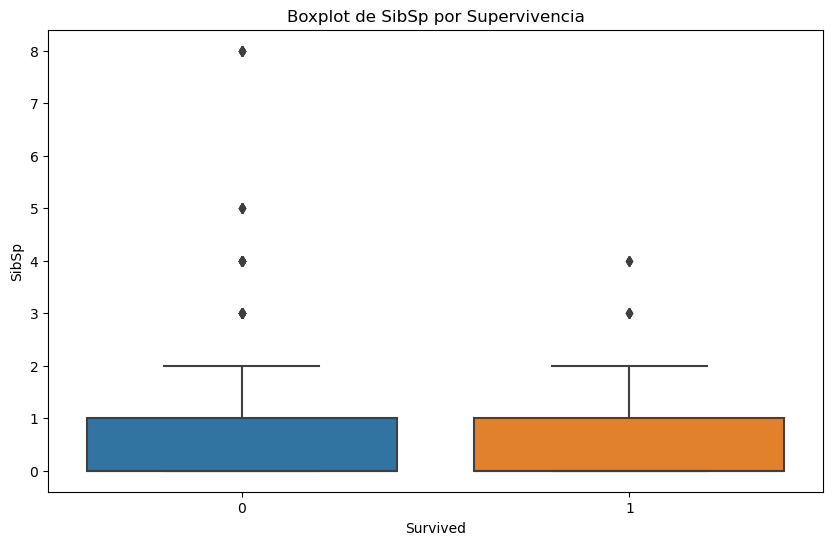

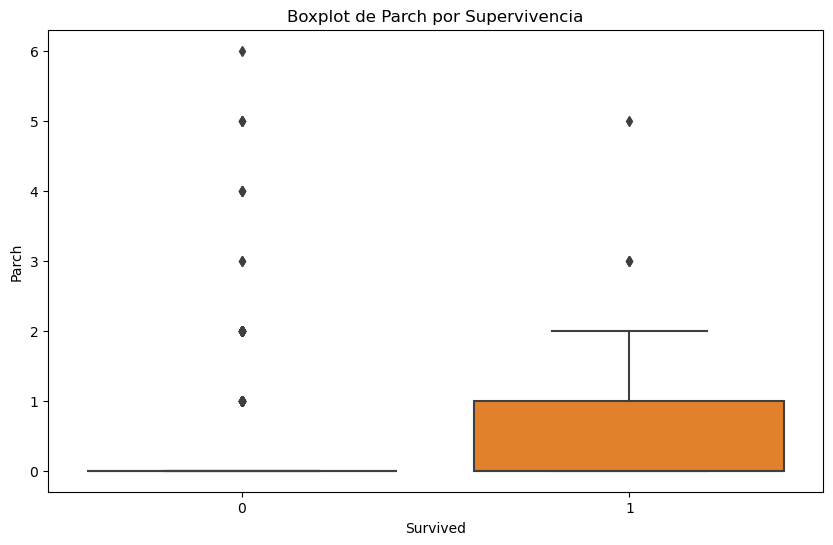

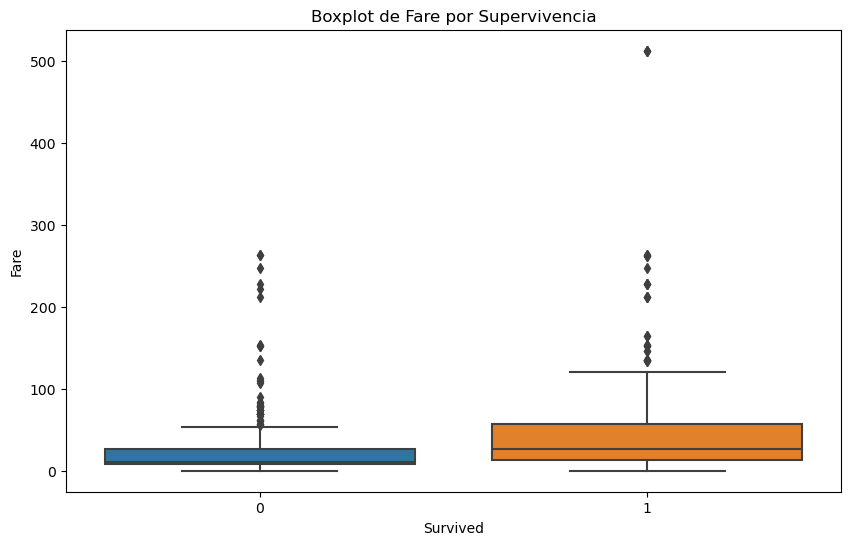

               Importance
Sex_male         0.236279
Age              0.223768
Fare             0.216271
Pclass           0.069993
SibSp            0.047870
Parch            0.034946
Cabin_Unknown    0.031046
Embarked_S       0.021600
Embarked_Q       0.009942
Cabin_C22 C26    0.003528
Logistic Regression: Best Params: {'C': 1}
Decision Tree: Best Params: {'max_depth': 3}
Random Forest: Best Params: {'n_estimators': 100}
Gradient Boosting: Best Params: {'learning_rate': 0.2}
SVM: Best Params: {'C': 1}
KNN: Best Params: {'n_neighbors': 7}
                     Accuracy  Precision    Recall  F1-score   ROC AUC
Logistic Regression  0.820896   0.800000  0.756757  0.777778  0.870316
Decision Tree        0.809701   0.812500  0.702703  0.753623  0.844379
Random Forest        0.776119   0.742857  0.702703  0.722222  0.870144
Gradient Boosting    0.813433   0.814433  0.711712  0.759615  0.866414
SVM                  0.813433   0.858824  0.657658  0.744898  0.861192
KNN                  0.791045  

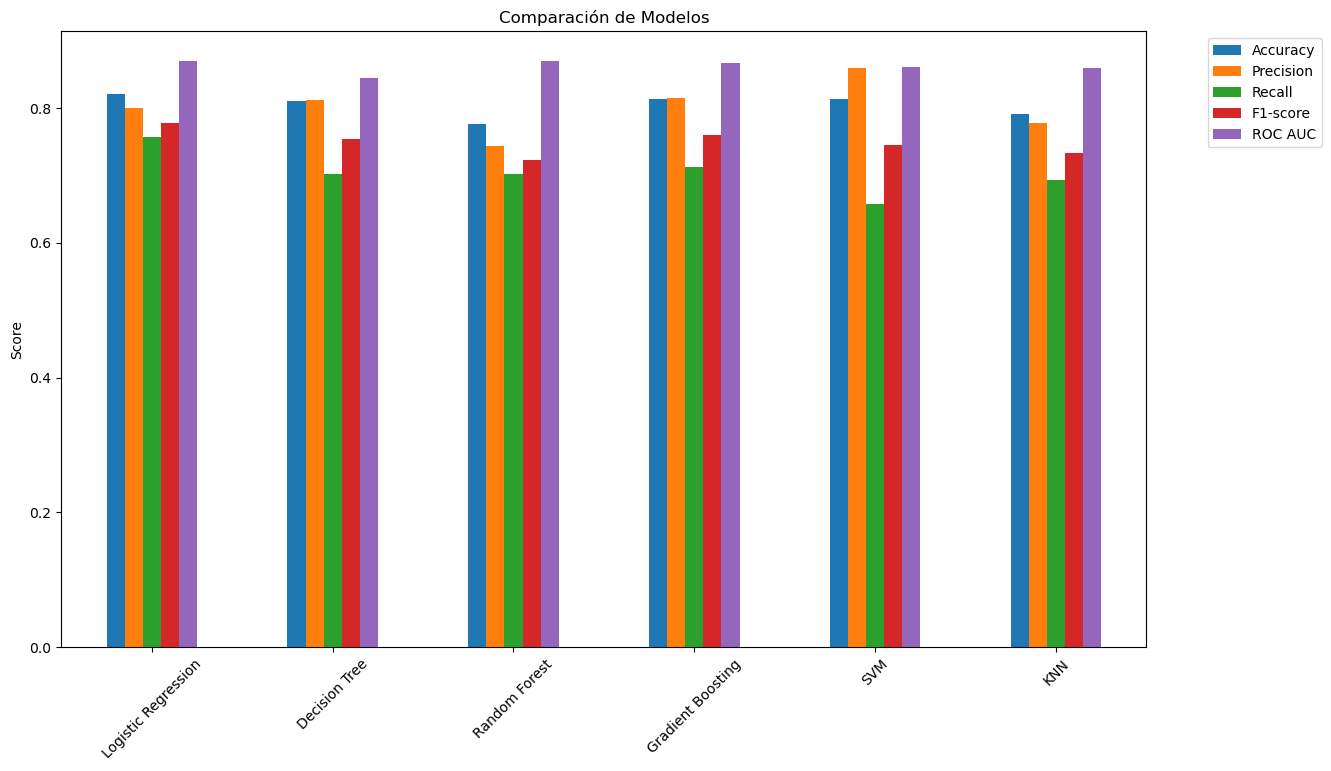

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Cargar el dataset
df = pd.read_csv(r"C:\Users\jengu\Titanic-Dataset.csv")

# Análisis exploratorio de datos
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df)
plt.title('Distribución de Supervivencia')
plt.show()

# Imputar valores faltantes en columnas numéricas
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Imputar valores faltantes en columnas categóricas
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Cabin'].fillna('Unknown', inplace=True)

# Eliminar columnas que no son necesarias para el análisis
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Convertir variables categóricas en variables dummy
df = pd.get_dummies(df, columns=['Sex', 'Cabin', 'Embarked'], drop_first=True)

# Análisis de correlación entre variables numéricas
numeric_features = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Boxplots para detectar valores atípicos
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Survived', y=feature, data=df)
    plt.title(f'Boxplot de {feature} por Supervivencia')
    plt.show()

# Selección de características usando Random Forest
X = df.drop('Survived', axis=1)
y = df['Survived']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances.head(10))

selected_features = feature_importances.head(10).index
X_selected = X[selected_features]

# Normalización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=X_selected.columns)

# Dividir el dataset en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definir los modelos y sus hiperparámetros
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 7]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 0.2]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]})
}

best_models = {}
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"{model_name}: Best Params: {grid_search.best_params_}")

# Evaluación de los modelos
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC AUC': roc_auc
    }

results_df = pd.DataFrame(results).T
print(results_df)

# Visualización de los resultados
results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comparación de Modelos')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

